In [50]:
import numpy as np
import pandas as pd
import sklearn.ensemble
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

### import Aaron cleaned basement.csv data and parsing it accordingly

In [51]:
data = pd.read_csv('../Fez/basement.csv')

#training is data with SalePrice!=0
training = data.loc[data.SalePrice!=0]
testing=data.loc[data.SalePrice==0]
xtesting=data.loc[:, data.columns !='SalePrice']

### XGBoost modeling

In [52]:
#X is everything but SalePrice, and y is SalePrice
X = training.loc[:, training.columns !='SalePrice']
y = np.log(training[['SalePrice']])

#setting up the dataframe optimally for xgboost
from xgboost import XGBRegressor

test_dmatrix = xgb.DMatrix(data=X, label=y)

In [53]:
#set parameters for xgb, randomly.
##might come back to hypertune parameters to improve modeling
xgb = XGBRegressor()
xgb.set_params(random_state=123)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [54]:
#set up test and train split from the training data set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


In [55]:
#running the model
xgb.fit(X_train, y_train)

[15:27:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [56]:
#print out the R^2
print("The train set R^2 is: %.5f" % xgb.score(X_train, y_train))
print("The test set R^2 is is: %.5f" % xgb.score(X_test, y_test))

The train set R^2 is: 0.95504
The test set R^2 is is: 0.89569


In [57]:
#Getting the error stats from the x_test

xgb_pred = xgb.predict(X_test)

# Calculate the absolute errors
errors = abs(np.expm1(xgb_pred).shape-np.expm1(y_test).values)

# Print out MAE, MSE, and RMSE
print('Mean Absolute Error (MAE): $', round(np.mean(errors), 2))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, xgb_pred))
print('Root Mean Square Error (RMSE):', np.sqrt(mean_squared_error(y_test, xgb_pred)))


Mean Absolute Error (MAE): $ 178355.76
Mean Squared Error (MSE): 0.01653643639302307
Root Mean Square Error (RMSE): 0.1285940760417177


In [58]:
# setting the y_test and y_train
y_train_xgboost = xgb.predict(X_train)
y_test_xgboost = xgb.predict(X_test)
y_submit=xgb.predict(xtesting)

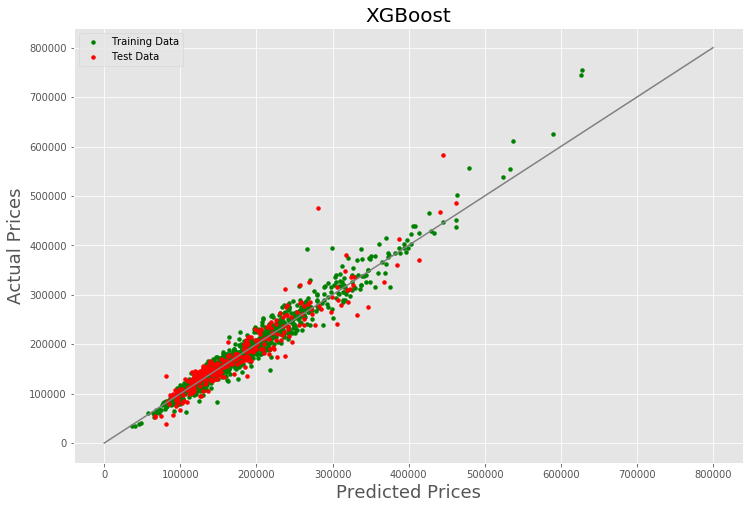

In [59]:
#setting up a scatter plot of y_test and y_train

plt.figure(figsize=(12,8))
plt.scatter(np.expm1(y_train_xgboost), np.expm1(y_train), c='green', marker='o', s=15, label="Training Data")
plt.scatter(np.expm1(y_test_xgboost), np.expm1(y_test), c='red', marker='o', s=15, label="Test Data")
plt.title("XGBoost", fontsize=20)
plt.xlabel('Predicted Prices', fontsize=18)
plt.ylabel('Actual Prices', fontsize=18)
plt.legend(loc = "upper left")
plt.plot([0, 800000], [0, 800000], c = "grey")
plt.show()

### XGB Feature Importance

In [60]:
# Get features and associated importance
feature_importances_xgb = [(feature, round(importance, 5)) for feature, importance in zip(X_train.columns, list(xgb.feature_importances_))]

#sort the feature importance
xgb_feature_sorted = sorted(feature_importances_xgb, key = lambda x: x[1], reverse = True )
xgb_feature_sorted = pd.DataFrame(xgb_feature_sorted, columns=['Feature','Importance'])
xgb_feature_sorted_most = xgb_feature_sorted.loc[xgb_feature_sorted['Importance']>0.01]
xgb_feature_sorted_most


,Feature,Importance
0,ExterQual__TA,0.12095
1,KitchenQual__TA,0.07667
2,GarageCars,0.07237
3,GarageType__Attchd,0.06386
4,YearBuilt,0.05065
5,Fireplaces,0.04806
6,BsmtQual__Ex,0.04414
7,GrLivArea,0.04120
8,CentralAir__N,0.03891
9,TotalBsmtSF,0.03777


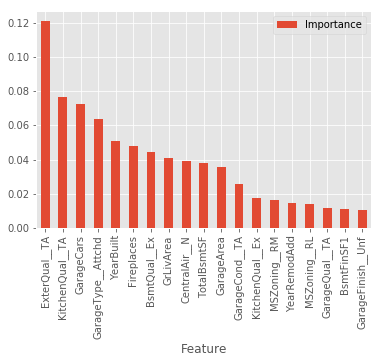

In [43]:
#makes a graph of important features
pd.DataFrame(np.expm1(y_submit)).to_csv('xingXG.csv')
ax = xgb_feature_sorted_most.plot.bar(x='Feature',rot=90)


## Random Forest

In [62]:
from sklearn.ensemble import RandomForestRegressor


In [63]:
#set up dataset for random forrest and fit
rforest = RandomForestRegressor()

rforest.set_params(random_state=52)

# Train the model on training data
rforest.fit(X_train, y_train)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=52, verbose=0, warm_start=False)

In [64]:
print("The train set R^2 is: %.5f" % rforest.score(X_train, y_train))
print("The test set R^2 is is: %.5f" % rforest.score(X_test, y_test))


The train set R^2 is: 0.97412
The test set R^2 is is: 0.86533


In [65]:
# Initial prediction
rforest_pred = rforest.predict(X_test)

# Calculate the absolute errors
errors = abs(np.expm1(rforest_pred) - np.expm1(y_test).values)

# Print out MAE, MSE, and RMSE
print('Mean Absolute Error (MAE): $', round(np.mean(errors), 2))
print('Mean Squared Error (MSE):', mean_squared_error(y_test, rforest_pred))
print('Root Mean Square Error (RMSE):', np.sqrt(mean_squared_error(y_test, rforest_pred)))

Mean Absolute Error (MAE): $ 74542.86
Mean Squared Error (MSE): 0.021350230733625592
Root Mean Square Error (RMSE): 0.1461171815141039


In [66]:
#set up y_train and y_test
y_train_rForest = rforest.predict(X_train)
y_test_rForest = rforest.predict(X_test)
y_submit = rforest.predict(xtesting)

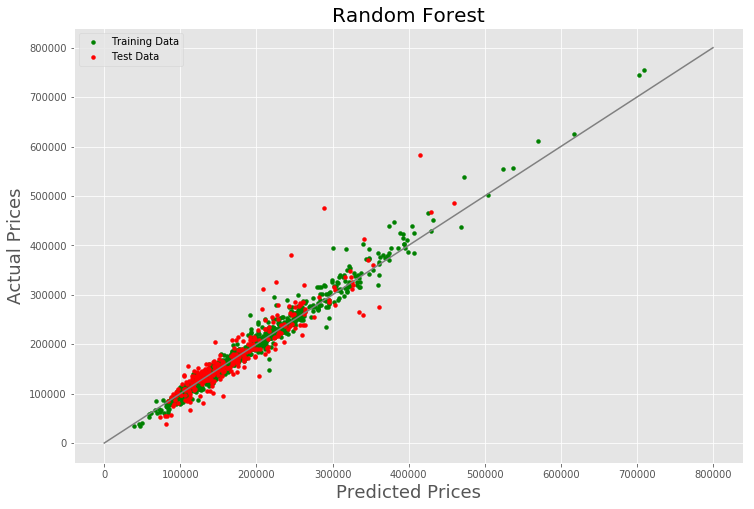

In [67]:
#setting up a scatter plot of y_test and y_train

plt.figure(figsize=(12,8))
plt.scatter(np.expm1(y_train_rForest), np.expm1(y_train), c='green', marker='o', s=15, label="Training Data")
plt.scatter(np.expm1(y_test_rForest), np.expm1(y_test), c='red', marker='o', s=15, label="Test Data")
plt.title("Random Forest", fontsize=20)
plt.xlabel('Predicted Prices', fontsize=18)
plt.ylabel('Actual Prices', fontsize=18)
plt.legend(loc = "upper left")
plt.plot([0, 800000], [0, 800000], c = "grey")
plt.show()

## Random Forest Feature Importance

In [68]:
# Get numerical feature importances

# List of tuples with variable and importance
features_rf_importance = [(feature, round(importance, 5)) for feature, importance in zip(X_train.columns, list(rforest.feature_importances_))]
features_rf_importance

# Sort the feature importances by most important first
features_rf_importance = sorted(features_rf_importance, key = lambda x: x[1], reverse = True )
features_rf_importance = pd.DataFrame(features_rf_importance, columns=['Feature','Importance'])
random_forest_features = features_rf_importance.loc[features_rf_importance['Importance']>0.01]


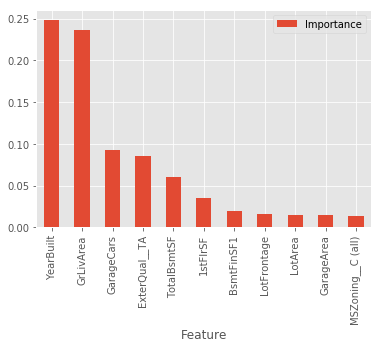

In [69]:
#Make a bar chart of importance.
ax = random_forest_features.plot.bar(x='Feature',rot=90)


In [70]:
pd.DataFrame(np.expm1(y_submit)).to_csv('xingRF.csv')